# Семинар 4: Методы оптимизации, PyTorch Lightning

## Вступление
На предыдущем курсе мы обсуждали с вами методы градиентного спуска и стохастического градиентного спуска. Для нейронных сетей обычно используют более продвинутые методы оптимизации, которые основаны на известном нам градиентном спуске. Сегодня мы посмотрим на то, как использовать их в **PyTorch**, а также разберём библиотеку **PyTorch Lightning**, позволяющую сократить количество кода, которое нам приходится писать на **PyTorch**.

### План семинара
1. Оптимизируем функцию одной переменной в **PyTorch**
2. Изучаем разные методы оптимизации
3. Работаем с PyTorch Optimizer
4. Работаем с PyTorch Scheduler
5. PyTorch VS PyTorch Lightning
6. Сравним работу разных оптимизаторов

In [1]:
# !pip3 install pytorch_lightning torchmetrics

In [2]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch import nn

In [3]:
def seed_everything(seed):
    # фискирует максимум сидов для корректности сравнения разных экспериментов
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(0xBADBEEF)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Our device is "{device}"')

Our device is "cpu"


## Оптимизируем функцию одной переменной в **PyTorch**
Как вам показали на лекции, большинство методов машинного обучения сводятся к простому поиску параметров, который бы минимизировал ошибку на тренировочной выборке:
$$
\min_{\theta}L(p_{\theta}(X), Y)
$$
Здесь:
* $L$ - некоторый лосс,
* $p_{\theta}$ - нейронная сеть с параметрами $\theta$
* $X$ - данные для обучения,
* $Y$ - ответы

Давайте руками напишем алгоритм для поиска минимума функции $f(x) = x^{3} - 2x^{2} + 2$.

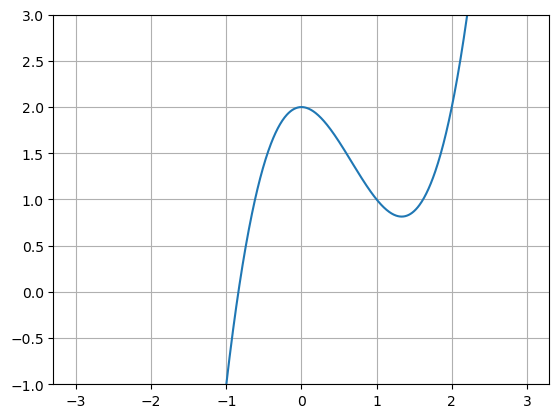

In [4]:
# наша функция f(x)
func = lambda x: x**3 - 2 * x**2 + 2
# производная функции f(x)
d_func = lambda x: 3 * x**2 - 4 * x
# сделаем массив из 1000 элементов от -3 до 3
x = np.linspace(-3, 3, 1000)
# определим границы по y для графика
plt.ylim([-1, 3])
plt.plot(x, func(x))
plt.grid()
plt.show()

Определим функцию для оптимизации $f(x)$, которая должна принимать на вход learning rate и максимальное количество итераций.

In [5]:
def find_minimum_first_order(
    learning_rate=0.01, eps=1e-4, max_iterations=1000, anneal_learning_rate=None
):
    i = 0
    x_old, x_new = 0, 2
    # будем сохранять историю значений x и y
    x_list, y_list = [x_old], [func(x_old)]
    if not anneal_learning_rate:
        anneal_learning_rate = lambda lr, step: lr

    # TODO:
    # Your code here
    # --------------
    while i < max_iterations and abs(x_new - x_old) > eps:
        learning_rate=anneal_learning_rate(learning_rate, i)
        x_old = x_new
        x_new = x_old - learning_rate * d_func(x_old)
        x_list.append(x_new)
        y_list.append(func(x_new))
        i += 1
    # --------------
    print("Найденный локальный минимум:", x_new)
    print("Количество шагов:", len(x_list))
    # Визуализируем сходимость
    plt.figure(figsize=[6, 4])
    plt.ylim([-3, 8])
    plt.scatter(x_list, y_list, c="r", edgecolors="k")
    plt.plot(x_list, y_list, c="r")
    plt.plot(x, func(x), c="b")
    plt.title("Descent trajectory")
    plt.grid()
    plt.show()

Попробуем различные `learning_rate` и посмотрим на поведение оптимизации.

Найденный локальный минимум: 1.3577577123861129
Количество шагов: 729


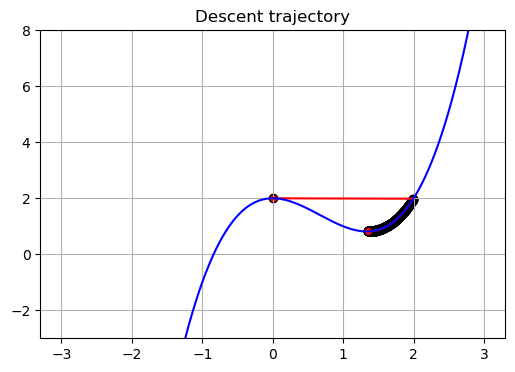

In [6]:
find_minimum_first_order(0.001)

Слишком мало, будем очень долго идти к локальному минимуму.

Найденный локальный минимум: 1.3356881625009205
Количество шагов: 129


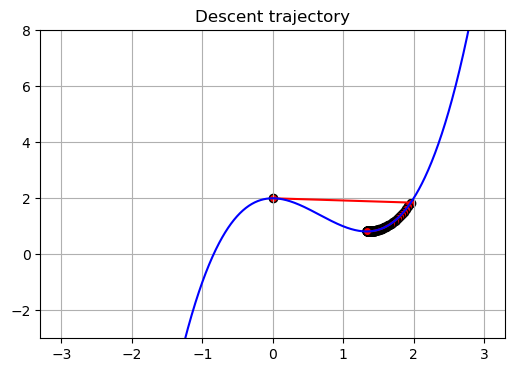

In [7]:
find_minimum_first_order(0.01)

Уже лучше.

Найденный локальный минимум: 1.3333495713163788
Количество шагов: 8


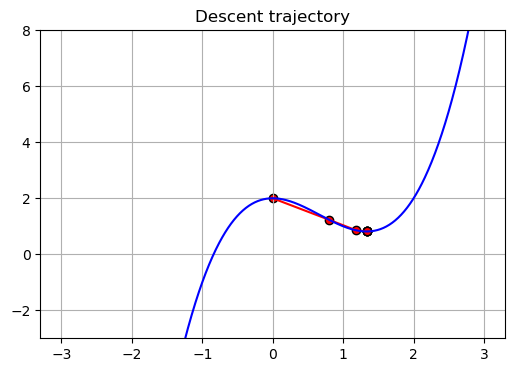

In [8]:
find_minimum_first_order(0.3)

In [9]:
find_minimum_first_order(0.6)

OverflowError: (34, 'Result too large')

Ууупс, получили Overflow. Значит learning rate слишком большой. Хотя большой learning rate опасен возможностью overflow у него есть ряд преимуществ. Чем больше темп обучения, тем большие расстояния мы преодолеваем за один шаг и тем выше вероятность быстрее найти хорошее пространство локальных минимумов.

Хорошая стратегия — начинать с достаточно большого шага (чтобы хорошо попутешествовать по функции), а потом постепенно его уменьшать, чтобы стабилизировать процесс обучения в каком-то локальном минимуме.

Найденный локальный минимум: 1.294744839667743
Количество шагов: 7


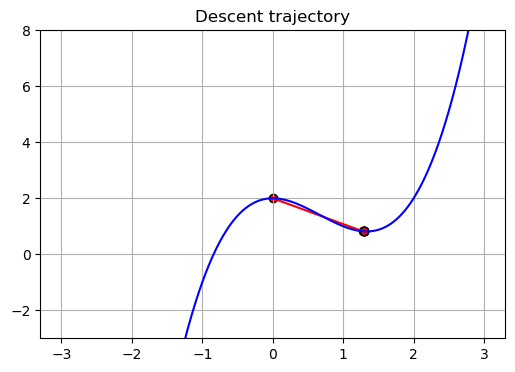

In [10]:
find_minimum_first_order(0.6, anneal_learning_rate=lambda lr, step: 0.3 * lr)

## Изучаем разные методы оптимизации

### Stochastic Gradient Descent
SGD - тот же самый gradient descent, что мы рассматривали ранее, но подсчёт градиентов производится не по всему множеству данных, а по отдельно взятому обьекту выборки. Очевидно, такая оптимизация будет очень шумной, что усложнит обучение модели. Поэтому обычно используют MiniBatch-SGD, где вместо одного сэмпла мы считаем градиент по $k$ обьектам. У такого подхода ниже дисперсия в сравнении с обычным SGD, что приводит к более стабильному процессу оптимизации, но контролируя $k$ мы можем контролировать используемую память.

$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
w &=& w - \eta \times g
\end{eqnarray}
$$

### Stochastic Gradient Descent with Momentum
Попытаемся добавить в SGD эффект инерции. Теперь, вместо того чтобы двигаться строго в направлении градиента в каждой точке, мы стараемся продолжить движение в том же направлении, в котором двигались ранее. То есть у нашей точки, которая спускается по многомерной поверхности, появляется импульс (momentum), который контролируется при помощи параметра $\alpha$. Он определяет какую часть прошлого градиента мы хотим использовать на текущем шаге.
$$
\begin{eqnarray}
g_{t} &=& \alpha g_{t-1} + \eta \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
w &=& w - \eta \times g
\end{eqnarray}
$$

![Momentum](static/sgd_momentum.png)

### Адаптивные варианты градиентного спуска
Во всех предыдущих алгоритмах у нас был фиксированный learning rate. Теперь рассмотрим алгоритмы, которые подстраивают learning rate в зависимости от текущего процесса обучения. Они называются адаптивными вариантами градиентного спуска.

Адаптивные варианты градиентного спуска подстраивают темп обучения таким образом, чтобы делать разные обновления для разных параметров. Например, может так сложиться, что некоторые веса близки к своим локальным минимумам, тогда по этим координатам нужно двигаться медленнее, а другие веса гораздо дальше от оптимума, значит их можно менять бОльшими шагами. Подобные методы часты приводят к более устойчивой модели и сходятся гораздо быстрее.

#### Adagrad
$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
s &=& s + diag(gg^{T}) \\
w &=& w - \frac{\eta}{\sqrt{s+eps}} \odot g
\end{eqnarray}
$$
Теперь нам не нужно сильно волноваться о правильном подборе $\eta$, так как $s$ контролирует скорость обучения для каждого параметра.

#### RMSprop
У Adagrad есть сильный минус. $s$ - всегда положительна и постоянно растёт во время обучения, что приводит к ситуации, где learning rate становится слишком маленький, и мы перестаём учиться. RMSprop решает эту проблему при помощи экспоненциального сглаживания:

$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
s &=& \rho s + (1 - \rho) diag(gg^{T}) \\
w &=& w - \frac{\eta}{\sqrt{s+eps}} \odot g
\end{eqnarray}
$$

#### Adam
Добавим не только моменты второго порядка, но и первого при обновлении параметров:

$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

#### Схема
![Sheme](static/gd_scheme.png)

### Работаем с PyTorch Optimizer

Очевидно, что для своих нейронных сетей не нужно каждый раз писать свой алгоритм и за вас уже сделаны все самые популярные методы. Их можно найти в **torch.optim** или по [ссылке](https://pytorch.org/docs/stable/optim.html#algorithms).

In [11]:
[elem for elem in dir(torch.optim) if not elem.startswith("_")]

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 'lr_scheduler',
 'swa_utils']

Основные методы PyTorch Optimizer:
* __step__ - обновление весов модели
* __zero_grad__ - занулить веса модели (по умолчанию градиенты в PyTorch аккумулируются) ~ `for each param in params: param.grad = None`
* __state_dict__ - получить текущее состояние Optimizer. Для адаптивных методов тут будут храниться аккумулированные квадраты градиентов


### Как создать инстанс PyTorch Optimizer?

Для того чтобы создать инстанс оптимизатора, достаточно передать ему параметры модели (их можно получить при помощи функции `parameters()`) и гиперпараметры для метода оптимизации.

Пример:

In [12]:
?torch.optim.SGD

In [13]:
model = torch.nn.Linear(1, 1)
list(model.named_parameters()), torch.optim.SGD(model.parameters(), lr=0.01)

([('weight',
   Parameter containing:
   tensor([[-0.1194]], requires_grad=True)),
  ('bias',
   Parameter containing:
   tensor([0.4259], requires_grad=True))],
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

Или же вот так:

In [14]:
# Зададим PyTorch модули в качестве словаря
model = torch.nn.ModuleDict(
    {"linear_1": torch.nn.Linear(1, 1), 
     "linear_2": torch.nn.Linear(2, 2)}
)
torch.optim.SGD(
    [
        {"params": model["linear_1"].parameters(), "lr": 0.3},
        {"params": model["linear_2"].parameters()},
    ],
    lr=0.5,
)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.3
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.5
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Последнее очень полезно, например, для transfer learning, когда мы хотим, чтобы предобученная модель тренировалась с другим learning rate.

**Важный момент:** даже если у вас есть методы с адаптивным градиентом спуском, полностью забывать о настройке learning rate не стоит.

### Работаем с PyTorch Scheduler

В начале семинара мы уменьшили количество шагов до сходимости следующим образом: начали с достаточно большого шага, а потом постепенно его уменьшили, чтобы стабилизировать процесс обучения в минимуме. Оказывается есть много способов менять оптимизацию таким образом. Они называются Schedulers.

In [15]:
[elem for elem in dir(torch.optim.lr_scheduler) if not elem.startswith("_")]

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'EPOCH_DEPRECATION_WARNING',
 'ExponentialLR',
 'LRScheduler',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'PolynomialLR',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR',
 'bisect_right',
 'inf',
 'math',
 'types',
 'warnings',
 'weakref',
 'wraps']

Основные методы PyTorch Scheduler:
* __step__ - обновление размера шага. *Обычно вызывается **1 раз за эпоху**, а не каждый шаг оптимизатора.*
* __state_dict__ - получить текущее состояние Scheduler: текущий LR, количество пройденных шагов и дополнительные параметры.


### Как создать инстанс PyTorch Scheduler?

Достаточно передать `optimizer` и гиперпараметры для метода.

Пример:

In [16]:
model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler_func = lambda epoch: 0.65**epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, scheduler_func)

Сделаем пару небольших функций для отрисовки изменения шага обучения на разных шедулерах:

In [17]:
def get_simple_model_optimizer():
    simple_model = torch.nn.Linear(2, 1)
    simple_optimizer = torch.optim.SGD(model.parameters(), lr=100)
    return simple_model, simple_optimizer


def draw_learning_rate_curve(optimizer, scheduler):
    lrs = []
    for i in range(100):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
    plt.grid()
    plt.plot(range(100), lrs)

### Примеры различных шедулеров в **PyTorch**

#### Lambda LR
Умножает шаг на значение данной ему функции: $lr_{epoch} = lr_{initial} * Lambda(epoch)$.

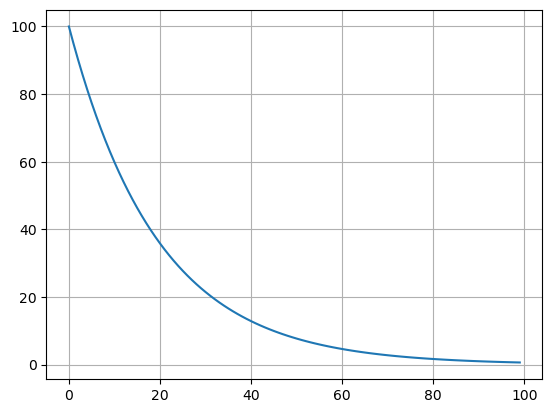

In [18]:
model, optimizer = get_simple_model_optimizer()
lambda_func = lambda epoch: 0.95**epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
draw_learning_rate_curve(optimizer, scheduler)

#### StepLR
Каждые `step_size` эпох уменьшает LR в `gamma` раз.

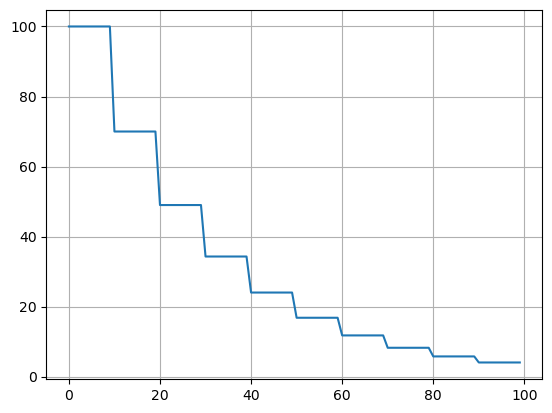

In [19]:
model, optimizer = get_simple_model_optimizer()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
draw_learning_rate_curve(optimizer, scheduler)

#### CosineAnnealingLR

Важно понимать, что LR имеет смысл не только снижать, но иногда еще и делать цикличным. Формула тут несколько сложнее, оставим ее для интересующихся)

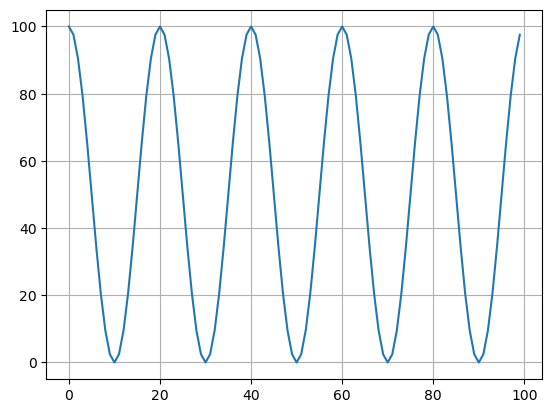

In [20]:
model, optimizer = get_simple_model_optimizer()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
draw_learning_rate_curve(optimizer, scheduler)

## PyTorch VS PyTorch Lightning

**PyTorch Lightning** это фреймворк для организованной работы с **PyTorch**. В нем упрощена работа по:
- Написанию тренировочного цикла
- Написанию датасетов
- Использованию gpu/tpu/ipu/hpu и тд
- Переводу моделей в формат ONNX
- И многому другому

Фреймворк призван оставить юзеру возможность конфигурировать параметры и проводить эксперименты, а остальное он возьмет на себя. Давайте сравним код на **PyTorch** без и с использованием **Lightning** на примере несложной нейросети на датасете FashionMNIST.

In [21]:
from collections import defaultdict, namedtuple

import pytorch_lightning as pl
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# крутая библиотека с кучей метрик "из коробки"
from torchmetrics.functional import accuracy

### Данные (общее)

In [22]:
# Train data
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    "./data", download=True, transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = DataLoader(
    fashion_mnist_train, batch_size=128, shuffle=True, num_workers=4
)

# Validation data
fashion_mnist_val = torchvision.datasets.FashionMNIST(
    "./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
val_dataloader = DataLoader(fashion_mnist_val, batch_size=128, num_workers=4)

In [23]:
idx_to_label = defaultdict(
    None,
    {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    },
)

Ankle Boot


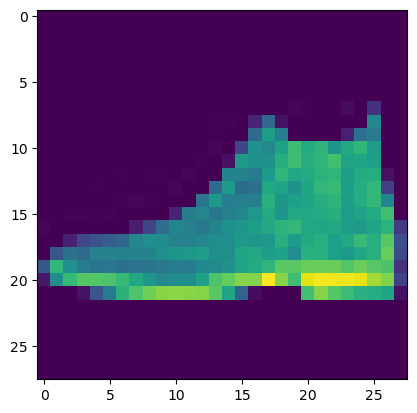

Coat
torch.Size([1, 28, 28])


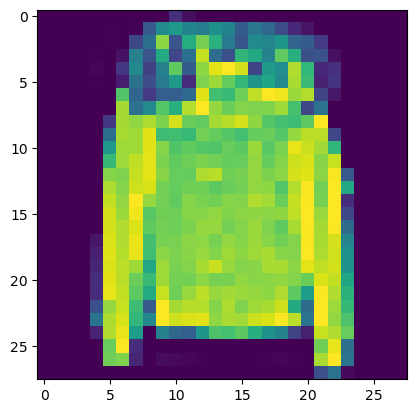

In [24]:
### pictures are normalized
for batch in val_dataloader:
    # batch_size is 128
    images, class_nums = batch
    print(idx_to_label[int(class_nums[0])])
    plt.imshow(images[0].squeeze())
    plt.show()
    print(idx_to_label[int(class_nums[127])])
    plt.imshow(images[127].squeeze())
    print(images[127].shape)
    plt.show()
    break

### Модель (общее)

Создайте класс модели по следующей схеме:

1. BatchNorm
2. Conv(out=32, kernel=3) -> ReLu -> MaxPool(kernel=2)
3. BatchNorm
4. Conv(out=64, kernel=3) -> ReLu -> MaxPool(kernel=2)
5. Flatten
6. Linear(out=128)
7. ReLu
8. Dropout
9. Linear(out=64)
10. ReLu
11. Linear(out=10)

In [79]:
class SimpleNet(torch.nn.Module):
    def __init__(self, dropout=0.4):
        super().__init__()
        # Your code here:
        # --------------
        self.batchnorm1 = nn.BatchNorm2d(1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            self.relu,
            self.maxpool,
        )
       
        self.batchnorm2 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            self.relu,
            self.maxpool,
        )
        
        self.linear1 = nn.Linear(in_features=64 * 5 * 5, out_features=128)
        self.linear2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout1d(p=dropout)
        self.output = nn.Linear(64, 10)

        # --------------
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        # runs the neural network
        # TODO:
        # Your code here
        # --------------
        x = self.batchnorm1(x)
        x = self.conv1(x)
        x = self.batchnorm2(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        return self.output(x)
        # --------------

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._forward(images)

        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(),
                                     self.targets.long(), 
                                     task='MULTICLASS', 
                                     num_classes=10)

        return loss

    def get_accuracy(self, reset=False):
        # return accuracy by all values till now
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

### Гиперпараметры

In [80]:
LossInfo = namedtuple(
    "LossInfo", ["full_train_losses", "train_epoch_losses", "eval_epoch_losses"]
)
EPOCHS = 10
LR = 0.001

### Тренировочные циклы (PyTorch)

Здесь нам надо будет объявить функции `train_epoch`, `validate`, `fit`.
Структура, напомним, выглядит, в упрощенном виде, так:
```
def train_epoch():
    for batch in train_loader:
        train_model_on_batch()
def validate():
    for batch in val_loader:
        validate_model_on_batch()
def fit():
    for epoch in range(1, num_epochs):
        train_epoch()
        validate()
```
Но на деле это все намного сложнее:

In [59]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    return_losses=False,
    device="cuda:0",
):
    model = model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            # move Batch to GPU
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            # update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # update description for tqdm
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
            all_losses.append(loss.detach().item())
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    return metrics

In [60]:
def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    scheduler=None,
    device="cuda:0",
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        # construct iterators
        train_iterator = iter(train_data_loader)
        validation_iterator = iter(validation_data_loader)
        # train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_iterator,
            optimizer=optimizer,
            return_losses=True,
            device=device,
        )
        # save train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model, data_loader=validation_iterator, device=device
            )
        # save eval losses
        epoch_eval_losses.append(validation_metrics["loss"])
        # scheduler step
        if scheduler:
            scheduler.step()
    return LossInfo(all_train_losses, epoch_train_losses, epoch_eval_losses)

In [61]:
# проверим, что всё работает (±1 минута на гпу):
model = SimpleNet().to(device)
_ = fit(
    model=model,
    epochs=1,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.SGD(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0

Loss: 2.2803 Accuracy: 12.0072:  14%|█▎        | 64/469 [00:08<00:28, 14.14it/s]


Loss: 2.2744 Accuracy: 13.7597:  28%|██▊       | 129/469 [00:13<00:24, 13.64it/s]


Loss: 2.266 Accuracy: 15.3983:  41%|████      | 193/469 [00:18<00:21, 12.97it/s]


Loss: 2.2356 Accuracy: 17.5644:  55%|█████▍    | 257/469 [00:22<00:15, 13.94it/s]


Loss: 2.22 Accuracy: 19.4266:  68%|██████▊   | 321/469 [00:27<00:10, 14.11it/s]


Loss: 2.2034 Accuracy: 21.3799:  82%|████████▏ | 385/469 [00:32<00:06, 13.60it/s]


Loss: 2.168 Accuracy: 23.3296:  96%|█████████▌| 449/469 [00:37<00:01, 13.33it/s]


Loss: 2.1603 Accuracy: 23.88: 100%|██████████| 469/469 [00:39<00:00, 11.91it/s]
Validation Epoch: 0

Loss: 2.1587 Accuracy: 44.4155:  67%|██████▋   | 53/79 [00:01<00:00, 29.85it/s]


Loss: 2.1329 Accuracy: 44.88: 100%|██████████| 79/79 [00:03<00:00, 25.15it/s]


### Тренировочные циклы (Lightning)

Здесь будет немного другая структура.

1) Создается 1 класс отнаследованный от `pl.LightningModule`. В нем описывается сама модель, необходимые функции тренировочного и валидационного шага.

2) Создается объект класса `pl.Trainer` с параметрами (напр. номер гпу, кол-во эпох, град. клиппинг и так далее) дока [тут](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer) или [тут](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html?highlight=trainer#trainer-flags).

3) Вызывается `trainer.fit(model, train_loader, val_loader)`.


```
class MyModule(pl.LightningModule):
    def init():
        init_model()
    def forward():
        forward_model()
    def training_step():
        make_1_training_step()
    def validation_step():
        make_1_validation_step()

trainer = pl.Trainer(gpus=1, max_epochs=10)
trainer.fit(model, train_loader, val_loader)
```
Поскольку у нас уже есть модель `SimpleNet`, то исправлять нам много не надо.

In [76]:
# 1) create a LightningModule
class SimpleModule(pl.LightningModule):
    def __init__(self, model, learning_rate, optimizer):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.optimizer = optimizer

    def forward(self, x):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = self.optimizer
        return optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        loss = self.model(images, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )  # сохраняет логи в папку, но можно несложно добавить wandb
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        loss = self.model(images, target)
        self.log("val_loss", loss, prog_bar=True)

In [81]:
# 2) create module

model = SimpleNet().to(device)
module = SimpleModule(model, learning_rate=LR, optimizer=torch.optim.Adam(model.parameters(), lr=LR))

# 3) create Trainer and train (±30 seconds on gpu)
trainer = pl.Trainer(accelerator="cpu", max_epochs=1)
trainer.fit(module, train_dataloader, val_dataloader)

# 3.5) we can also find best learning rate like this: https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html
# trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)
# trainer.tune(module, train_dataloader, eval_dataloader)
# trainer.fit(module, train_dataloader, eval_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleNet | 232 K 
------------------------------------
232 K     Trainable params
0         Non-trainable params
232 K     Total params
0.931     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Обратите внимание **насколько** поведение `trainer.fit()` сильно похоже на написанную нами ранее функцию `fit()`


Заметьте также, что на Lightning мы:
1.   Не описывали тренировочный цикл ни по эпохам, ни по батчам
2.   Не рисковали забыть zero_grad, .backward()
3.   Не переносили ни модель, ни данные на GPU
4.   Получили всякие приколы типа auto_lr_find 
5.   Сохранили возможность использования многих тонкостей **PyTorch** типа [schedulers](https://pytorch-lightning.readthedocs.io/en/stable/common/optimization.html), логирование через [wandb](https://docs.wandb.ai/guides/integrations/lightning) и так далее

## Сравнением работу разных оптимизаторов

### SGD

In [64]:
model = SimpleNet().to(device=device)
sgd_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.SGD(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0

Loss: 2.3175 Accuracy: 10.9255:  14%|█▎        | 64/469 [00:08<00:29, 13.82it/s]


Loss: 2.2876 Accuracy: 12.0216:  28%|██▊       | 129/469 [00:13<00:25, 13.42it/s]


Loss: 2.2775 Accuracy: 13.2408:  41%|████      | 193/469 [00:18<00:21, 12.81it/s]


Loss: 2.2641 Accuracy: 14.786:  55%|█████▍    | 257/469 [00:22<00:15, 13.27it/s]


Loss: 2.2606 Accuracy: 16.2042:  68%|██████▊   | 321/469 [00:27<00:10, 13.94it/s]


Loss: 2.2331 Accuracy: 17.7476:  82%|████████▏ | 385/469 [00:31<00:06, 13.14it/s]


Loss: 2.2219 Accuracy: 19.2215:  96%|█████████▌| 449/469 [00:36<00:01, 14.38it/s]


Loss: 2.2301 Accuracy: 19.7767: 100%|██████████| 469/469 [00:38<00:00, 12.15it/s]
Validation Epoch: 0

Loss: 2.2165 Accuracy: 33.5938:  66%|██████▌   | 52/79 [00:01<00:00, 29.69it/s]


Loss: 2.206 Accuracy: 33.47: 100%|██████████| 79/79 [00:03<00:00, 24.67it/s]   
Train Epoch: 1

Loss: 2.2045 Accuracy: 30.8594:   9%|▉         | 42/469 [00:07<00:33, 12.74it/s]


Loss: 2.1959 Accuracy: 32.4985:  23%|██▎       | 106/469 [00:11<00:25, 14.42it/s]


Loss: 2.1781 Accuracy: 33.8222:  36%|███▌      | 170/469 [00:16<00:22, 13.47it/s]


Loss: 2.1402 Accuracy: 35.0898:  50%|████▉     | 234/469 [00:21<00:16, 14.07it/s]


Loss: 2.1321 Accuracy: 36.3739:  64%|██████▎   | 298/469 [00:25<00:12, 13.41it/s]


Loss: 2.0705 Accuracy: 37.3945:  77%|███████▋  | 362/469 [00:30<00:07, 13.94it/s]


Loss: 2.0535 Accuracy: 38.2264:  91%|█████████ | 426/469 [00:35<00:03, 13.46it/s]


Loss: 2.0111 Accuracy: 38.7217: 100%|██████████| 469/469 [00:39<00:00, 11.98it/s]
Validation Epoch: 1

Loss: 2.0389 Accuracy: 50.7812:  32%|███▏      | 25/79 [00:00<00:02, 26.45it/s]


Loss: 1.97 Accuracy: 51.0: 100%|██████████| 79/79 [00:03<00:00, 23.50it/s]     
Train Epoch: 2

Loss: 2.0082 Accuracy: 42.8385:   4%|▎         | 17/469 [00:05<00:48,  9.30it/s]


Loss: 1.9477 Accuracy: 44.0512:  17%|█▋        | 82/469 [00:10<00:28, 13.52it/s]


Loss: 1.9179 Accuracy: 44.4303:  31%|███       | 146/469 [00:15<00:24, 13.28it/s]


Loss: 1.8624 Accuracy: 45.0385:  45%|████▍     | 210/469 [00:19<00:18, 13.90it/s]


Loss: 1.8081 Accuracy: 45.2415:  58%|█████▊    | 274/469 [00:24<00:14, 13.39it/s]


Loss: 1.7636 Accuracy: 45.4715:  72%|███████▏  | 338/469 [00:29<00:10, 12.79it/s]


Loss: 1.669 Accuracy: 46.0337:  86%|████████▌ | 402/469 [00:34<00:05, 12.88it/s] 


Loss: 1.6308 Accuracy: 46.5521:  99%|█████████▉| 466/469 [00:39<00:00, 13.39it/s]


Loss: 1.6856 Accuracy: 46.545: 100%|██████████| 469/469 [00:40<00:00, 11.70it/s]
Validation Epoch: 2

Loss: 1.5274 Accuracy: 56.5173:  95%|█████████▍| 75/79 [00:02<00:00, 28.96it/s]


Loss: 1.467 Accuracy: 56.53: 100%|██████████| 79/79 [00:03<00:00, 25.30it/s]   
Train Epoch: 3

Loss: 1.5693 Accuracy: 49.9874:  13%|█▎        | 61/469 [00:08<00:28, 14.26it/s]


Loss: 1.4815 Accuracy: 50.7566:  27%|██▋       | 126/469 [00:13<00:24, 13.77it/s]


Loss: 1.449 Accuracy: 51.4848:  41%|████      | 190/469 [00:18<00:21, 12.89it/s]


Loss: 1.4275 Accuracy: 51.9761:  54%|█████▍    | 254/469 [00:23<00:15, 13.75it/s]


Loss: 1.3766 Accuracy: 52.5789:  68%|██████▊   | 318/469 [00:27<00:11, 12.97it/s]


Loss: 1.3006 Accuracy: 53.1699:  81%|████████▏ | 382/469 [00:32<00:06, 12.47it/s]


Loss: 1.3006 Accuracy: 53.6388:  95%|█████████▌| 446/469 [00:37<00:01, 12.95it/s]


Loss: 1.2906 Accuracy: 53.74: 100%|██████████| 469/469 [00:39<00:00, 11.83it/s]
Validation Epoch: 3

Loss: 1.225 Accuracy: 62.5:  63%|██████▎   | 50/79 [00:01<00:00, 29.27it/s]


Loss: 1.0143 Accuracy: 63.02: 100%|██████████| 79/79 [00:03<00:00, 25.39it/s]  
Train Epoch: 4

Loss: 1.2232 Accuracy: 57.1456:   9%|▊         | 40/469 [00:07<00:33, 12.73it/s]


Loss: 1.2899 Accuracy: 58.2887:  22%|██▏       | 105/469 [00:11<00:25, 14.55it/s]


Loss: 1.1673 Accuracy: 58.5706:  36%|███▌      | 169/469 [00:16<00:20, 14.77it/s]


Loss: 1.1491 Accuracy: 58.6943:  50%|████▉     | 233/469 [00:20<00:16, 14.41it/s]


Loss: 1.1719 Accuracy: 58.962:  63%|██████▎   | 297/469 [00:25<00:12, 13.81it/s]


Loss: 1.2453 Accuracy: 59.3923:  77%|███████▋  | 361/469 [00:29<00:07, 14.92it/s]


Loss: 1.0629 Accuracy: 59.6636:  91%|█████████ | 425/469 [00:33<00:02, 15.02it/s]


Loss: 1.2174 Accuracy: 59.9483: 100%|██████████| 469/469 [00:37<00:00, 12.57it/s]
Validation Epoch: 4

Loss: 0.9899 Accuracy: 69.4661:  29%|██▉       | 23/79 [00:00<00:01, 28.74it/s]


Loss: 0.7944 Accuracy: 69.51: 100%|██████████| 79/79 [00:03<00:00, 24.09it/s]
Train Epoch: 5

Loss: 1.1344 Accuracy: 61.6268:   4%|▎         | 17/469 [00:05<00:46,  9.66it/s]


Loss: 1.0645 Accuracy: 62.0522:  17%|█▋        | 81/469 [00:09<00:26, 14.82it/s]


Loss: 1.0194 Accuracy: 62.6124:  31%|███       | 145/469 [00:14<00:22, 14.09it/s]


Loss: 1.0251 Accuracy: 63.2515:  45%|████▍     | 209/469 [00:18<00:17, 15.01it/s]


Loss: 1.048 Accuracy: 63.2784:  58%|█████▊    | 273/469 [00:22<00:13, 14.88it/s] 


Loss: 0.9948 Accuracy: 63.5471:  72%|███████▏  | 337/469 [00:27<00:09, 13.77it/s]


Loss: 0.976 Accuracy: 63.9381:  86%|████████▌ | 401/469 [00:32<00:05, 13.06it/s] 


Loss: 0.9641 Accuracy: 64.2184:  99%|█████████▉| 465/469 [00:37<00:00, 13.88it/s]


Loss: 1.0556 Accuracy: 64.2033: 100%|██████████| 469/469 [00:37<00:00, 12.37it/s]
Validation Epoch: 5

Loss: 0.922 Accuracy: 71.375:  94%|█████████▎| 74/79 [00:02<00:00, 30.54it/s]  


Loss: 0.67 Accuracy: 71.48: 100%|██████████| 79/79 [00:03<00:00, 25.23it/s]
Train Epoch: 6

Loss: 0.9511 Accuracy: 67.0703:  13%|█▎        | 60/469 [00:08<00:29, 14.01it/s]


Loss: 0.951 Accuracy: 66.6937:  26%|██▋       | 124/469 [00:13<00:24, 13.84it/s] 


Loss: 0.9333 Accuracy: 66.7865:  40%|████      | 188/469 [00:18<00:21, 13.35it/s]


Loss: 0.8784 Accuracy: 66.9806:  54%|█████▎    | 252/469 [00:23<00:16, 13.07it/s]


Loss: 0.8964 Accuracy: 67.291:  67%|██████▋   | 316/469 [00:28<00:10, 13.91it/s]


Loss: 0.9381 Accuracy: 67.4848:  81%|████████  | 380/469 [00:32<00:06, 13.50it/s]


Loss: 0.882 Accuracy: 67.6896:  95%|█████████▍| 444/469 [00:37<00:01, 13.04it/s]


Loss: 0.9191 Accuracy: 67.73: 100%|██████████| 469/469 [00:39<00:00, 11.78it/s]  
Validation Epoch: 6

Loss: 0.7699 Accuracy: 72.9114:  61%|██████    | 48/79 [00:01<00:00, 31.38it/s]


Loss: 0.6039 Accuracy: 73.21: 100%|██████████| 79/79 [00:03<00:00, 26.09it/s]  
Train Epoch: 7

Loss: 0.754 Accuracy: 69.1907:   8%|▊         | 39/469 [00:06<00:29, 14.45it/s]


Loss: 0.9696 Accuracy: 69.5012:  22%|██▏       | 103/469 [00:11<00:27, 13.41it/s]


Loss: 0.9117 Accuracy: 69.2057:  36%|███▌      | 167/469 [00:15<00:20, 14.82it/s]


Loss: 0.9303 Accuracy: 69.4471:  49%|████▉     | 231/469 [00:20<00:16, 14.27it/s]


Loss: 0.803 Accuracy: 69.5972:  63%|██████▎   | 295/469 [00:24<00:13, 12.94it/s] 


Loss: 0.9111 Accuracy: 69.7938:  77%|███████▋  | 359/469 [00:29<00:07, 14.37it/s]


Loss: 0.6813 Accuracy: 69.9145:  90%|█████████ | 423/469 [00:34<00:03, 13.83it/s]


Loss: 0.7314 Accuracy: 70.0067: 100%|██████████| 469/469 [00:37<00:00, 12.38it/s]
Validation Epoch: 7

Loss: 0.9866 Accuracy: 74.1168:  28%|██▊       | 22/79 [00:00<00:01, 31.20it/s]


Loss: 0.5699 Accuracy: 73.98: 100%|██████████| 79/79 [00:03<00:00, 25.52it/s]  
Train Epoch: 8

Loss: 0.7266 Accuracy: 70.4861:   4%|▍         | 18/469 [00:05<00:43, 10.41it/s]


Loss: 0.6342 Accuracy: 70.7831:  17%|█▋        | 82/469 [00:09<00:27, 13.95it/s]


Loss: 0.9351 Accuracy: 71.0087:  31%|███       | 146/469 [00:14<00:23, 13.73it/s]


Loss: 0.8726 Accuracy: 71.1012:  45%|████▍     | 210/469 [00:19<00:19, 13.07it/s]


Loss: 0.7712 Accuracy: 71.1818:  58%|█████▊    | 274/469 [00:23<00:14, 13.75it/s]


Loss: 0.8884 Accuracy: 71.2735:  72%|███████▏  | 338/469 [00:28<00:09, 14.00it/s]


Loss: 0.6727 Accuracy: 71.2721:  86%|████████▌ | 402/469 [00:33<00:04, 13.66it/s]


Loss: 0.6948 Accuracy: 71.3547:  99%|█████████▉| 466/469 [00:37<00:00, 14.30it/s]


Loss: 0.7924 Accuracy: 71.37: 100%|██████████| 469/469 [00:38<00:00, 12.25it/s] 
Validation Epoch: 8

Loss: 0.6951 Accuracy: 74.4963:  96%|█████████▌| 76/79 [00:02<00:00, 30.69it/s]


Loss: 0.5419 Accuracy: 74.58: 100%|██████████| 79/79 [00:03<00:00, 25.61it/s]  
Train Epoch: 9

Loss: 0.7174 Accuracy: 72.6811:  13%|█▎        | 62/469 [00:08<00:29, 13.83it/s]


Loss: 0.717 Accuracy: 72.1457:  27%|██▋       | 127/469 [00:13<00:24, 14.12it/s]


Loss: 0.6539 Accuracy: 72.1695:  41%|████      | 191/469 [00:17<00:19, 14.02it/s]


Loss: 0.7545 Accuracy: 72.1783:  54%|█████▍    | 255/469 [00:22<00:15, 13.80it/s]


Loss: 0.8544 Accuracy: 72.3893:  68%|██████▊   | 319/469 [00:26<00:10, 14.12it/s]


Loss: 0.6998 Accuracy: 72.5951:  82%|████████▏ | 383/469 [00:31<00:06, 14.01it/s]


Loss: 0.8502 Accuracy: 72.7279:  95%|█████████▌| 447/469 [00:35<00:01, 13.97it/s]


Loss: 0.628 Accuracy: 72.7517: 100%|██████████| 469/469 [00:37<00:00, 12.39it/s]
Validation Epoch: 9

Loss: 0.7422 Accuracy: 75.1406:  62%|██████▏   | 49/79 [00:01<00:01, 27.89it/s]


Loss: 0.5266 Accuracy: 75.32: 100%|██████████| 79/79 [00:03<00:00, 24.42it/s] 


### SGD with Momentum

In [69]:
model = SimpleNet().to(device=device)
sgd_momentum_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR),
    device=device,
)

Train Epoch: 0

Loss: 2.3116 Accuracy: 8.2031:   0%|          | 1/469 [00:04<31:03,  3.98s/it]


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Loss: 2.1067 Accuracy: 21.8284:  14%|█▍        | 66/469 [00:08<00:28, 13.93it/s]


Loss: 1.6953 Accuracy: 30.7789:  28%|██▊       | 131/469 [00:13<00:25, 13.19it/s]


Loss: 1.2309 Accuracy: 38.5737:  42%|████▏     | 195/469 [00:18<00:19, 14.00it/s]


Loss: 1.1165 Accuracy: 44.1874:  55%|█████▌    | 259/469 [00:22<00:15, 13.69it/s]


Loss: 0.8872 Accuracy: 48.5536:  69%|██████▉   | 323/469 [00:27<00:09, 14.78it/s]


Loss: 0.8295 Accuracy: 51.9885:  83%|████████▎ | 387/469 [00:31<00:06, 13.32it/s]


Loss: 0.851 Accuracy: 54.6546:  96%|█████████▌| 451/469 [00:36<00:01, 14.33it/s]


Loss: 0.8737 Accuracy: 55.375: 100%|██████████| 469/469 [00:38<00:00, 12.30it/s]
Validation Epoch: 0

Loss: 0.5796 Accuracy: 74.6931:  71%|███████   | 56/79 [00:01<00:00, 31.78it/s]


Loss: 0.4252 Accuracy: 74.83: 100%|██████████| 79/79 [00:03<00:00, 26.26it/s]  
Train Epoch: 1

Loss: 0.7084 Accuracy: 72.6902:  10%|▉         | 45/469 [00:07<00:31, 13.63it/s]


Loss: 0.6906 Accuracy: 73.6435:  23%|██▎       | 110/469 [00:11<00:25, 13.94it/s]


Loss: 0.6555 Accuracy: 74.2592:  37%|███▋      | 174/469 [00:16<00:21, 13.84it/s]


Loss: 0.6047 Accuracy: 74.7144:  51%|█████     | 238/469 [00:21<00:18, 12.40it/s]


Loss: 0.7393 Accuracy: 75.044:  64%|██████▍   | 302/469 [00:25<00:11, 13.93it/s]


Loss: 0.5258 Accuracy: 75.3031:  78%|███████▊  | 366/469 [00:30<00:07, 13.69it/s]


Loss: 0.5348 Accuracy: 75.6632:  92%|█████████▏| 430/469 [00:35<00:02, 13.63it/s]


Loss: 0.5248 Accuracy: 75.935: 100%|██████████| 469/469 [00:38<00:00, 12.14it/s] 
Validation Epoch: 1

Loss: 0.5806 Accuracy: 79.0885:  38%|███▊      | 30/79 [00:01<00:01, 28.90it/s]


Loss: 0.2617 Accuracy: 79.08: 100%|██████████| 79/79 [00:03<00:00, 25.03it/s]  
Train Epoch: 2

Loss: 0.5459 Accuracy: 79.9479:   5%|▍         | 23/469 [00:05<00:36, 12.15it/s]


Loss: 0.6619 Accuracy: 78.8352:  19%|█▉        | 88/469 [00:10<00:28, 13.59it/s]


Loss: 0.6063 Accuracy: 78.9011:  32%|███▏      | 152/469 [00:14<00:22, 14.09it/s]


Loss: 0.4405 Accuracy: 79.2535:  46%|████▌     | 216/469 [00:19<00:18, 13.64it/s]


Loss: 0.3961 Accuracy: 79.4503:  60%|█████▉    | 280/469 [00:23<00:13, 14.11it/s]


Loss: 0.5708 Accuracy: 79.583:  73%|███████▎  | 344/469 [00:28<00:09, 12.82it/s]


Loss: 0.5682 Accuracy: 79.7469:  87%|████████▋ | 408/469 [00:33<00:04, 13.92it/s]


Loss: 0.5422 Accuracy: 79.8733: 100%|██████████| 469/469 [00:38<00:00, 12.30it/s]
Validation Epoch: 2

Loss: 0.4708 Accuracy: 86.5234:   5%|▌         | 4/79 [00:00<00:02, 33.74it/s]


Loss: 0.2054 Accuracy: 82.09: 100%|██████████| 79/79 [00:03<00:00, 26.05it/s]  
Train Epoch: 3

Loss: 0.5882 Accuracy: 78.9062:   1%|          | 3/469 [00:04<09:04,  1.17s/it]


Loss: 0.5259 Accuracy: 81.4913:  14%|█▍        | 67/469 [00:08<00:28, 13.90it/s]


Loss: 0.4453 Accuracy: 82.0195:  28%|██▊       | 132/469 [00:13<00:23, 14.15it/s]


Loss: 0.4595 Accuracy: 82.0194:  42%|████▏     | 196/469 [00:18<00:19, 13.83it/s]


Loss: 0.4935 Accuracy: 82.0582:  55%|█████▌    | 260/469 [00:22<00:14, 13.97it/s]


Loss: 0.5566 Accuracy: 82.1995:  69%|██████▉   | 324/469 [00:27<00:10, 14.32it/s]


Loss: 0.3456 Accuracy: 82.222:  83%|████████▎ | 388/469 [00:31<00:05, 13.77it/s] 


Loss: 0.433 Accuracy: 82.3055:  96%|█████████▋| 452/469 [00:36<00:01, 13.71it/s] 


Loss: 0.4499 Accuracy: 82.34: 100%|██████████| 469/469 [00:38<00:00, 12.20it/s]
Validation Epoch: 3

Loss: 0.3852 Accuracy: 83.9036:  72%|███████▏  | 57/79 [00:01<00:00, 30.46it/s]


Loss: 0.1488 Accuracy: 84.08: 100%|██████████| 79/79 [00:03<00:00, 26.09it/s]  
Train Epoch: 4

Loss: 0.4687 Accuracy: 83.3444:  10%|█         | 47/469 [00:07<00:31, 13.34it/s]


Loss: 0.4296 Accuracy: 83.4542:  24%|██▎       | 111/469 [00:12<00:24, 14.34it/s]


Loss: 0.5634 Accuracy: 83.7846:  37%|███▋      | 175/469 [00:16<00:21, 13.53it/s]


Loss: 0.4098 Accuracy: 83.7305:  51%|█████     | 239/469 [00:21<00:16, 13.56it/s]


Loss: 0.3593 Accuracy: 83.9818:  65%|██████▍   | 303/469 [00:26<00:13, 12.04it/s]


Loss: 0.3389 Accuracy: 84.0926:  78%|███████▊  | 367/469 [00:31<00:07, 13.96it/s]


Loss: 0.4504 Accuracy: 84.2394:  92%|█████████▏| 431/469 [00:35<00:02, 14.32it/s]


Loss: 0.2885 Accuracy: 84.3233: 100%|██████████| 469/469 [00:38<00:00, 12.06it/s]
Validation Epoch: 4

Loss: 0.4031 Accuracy: 84.8485:  41%|████      | 32/79 [00:01<00:01, 27.90it/s]


Loss: 0.1192 Accuracy: 85.03: 100%|██████████| 79/79 [00:03<00:00, 24.19it/s] 
Train Epoch: 5

Loss: 0.4573 Accuracy: 85.7572:   5%|▌         | 25/469 [00:05<00:34, 12.76it/s]


Loss: 0.417 Accuracy: 85.2604:  19%|█▉        | 90/469 [00:10<00:27, 13.84it/s]


Loss: 0.4286 Accuracy: 85.2679:  33%|███▎      | 154/469 [00:15<00:24, 12.94it/s]


Loss: 0.4275 Accuracy: 85.4107:  46%|████▋     | 218/469 [00:19<00:18, 13.69it/s]


Loss: 0.4991 Accuracy: 85.6023:  60%|██████    | 282/469 [00:24<00:13, 14.37it/s]


Loss: 0.3185 Accuracy: 85.6462:  74%|███████▍  | 346/469 [00:28<00:09, 13.34it/s]


Loss: 0.4928 Accuracy: 85.5736:  87%|████████▋ | 410/469 [00:33<00:04, 13.88it/s]


Loss: 0.4156 Accuracy: 85.6183: 100%|██████████| 469/469 [00:38<00:00, 12.17it/s]
Validation Epoch: 5

Loss: 0.2704 Accuracy: 87.8348:   8%|▊         | 6/79 [00:00<00:02, 33.59it/s]


Loss: 0.1115 Accuracy: 86.14: 100%|██████████| 79/79 [00:03<00:00, 26.04it/s]  
Train Epoch: 6

Loss: 0.361 Accuracy: 87.0313:   1%|          | 4/469 [00:04<05:19,  1.45it/s] 


Loss: 0.499 Accuracy: 86.0937:  15%|█▍        | 69/469 [00:09<00:27, 14.66it/s] 


Loss: 0.4887 Accuracy: 86.4272:  28%|██▊       | 133/469 [00:13<00:23, 14.12it/s]


Loss: 0.3918 Accuracy: 86.3873:  42%|████▏     | 197/469 [00:18<00:20, 13.41it/s]


Loss: 0.3795 Accuracy: 86.3102:  56%|█████▌    | 261/469 [00:22<00:15, 13.60it/s]


Loss: 0.3034 Accuracy: 86.3209:  69%|██████▉   | 325/469 [00:27<00:10, 14.10it/s]


Loss: 0.32 Accuracy: 86.3782:  83%|████████▎ | 389/469 [00:32<00:05, 14.63it/s]  


Loss: 0.4145 Accuracy: 86.3952:  97%|█████████▋| 453/469 [00:36<00:01, 13.24it/s]


Loss: 0.2064 Accuracy: 86.4217: 100%|██████████| 469/469 [00:38<00:00, 12.16it/s]
Validation Epoch: 6

Loss: 0.2681 Accuracy: 86.3877:  73%|███████▎  | 58/79 [00:01<00:00, 29.43it/s]


Loss: 0.1001 Accuracy: 86.48: 100%|██████████| 79/79 [00:03<00:00, 25.13it/s]  
Train Epoch: 7

Loss: 0.388 Accuracy: 86.4258:  10%|█         | 47/469 [00:07<00:32, 12.99it/s] 


Loss: 0.3199 Accuracy: 86.8708:  24%|██▍       | 112/469 [00:12<00:27, 12.91it/s]


Loss: 0.393 Accuracy: 86.8026:  38%|███▊      | 176/469 [00:17<00:21, 13.84it/s] 


Loss: 0.3062 Accuracy: 86.8744:  51%|█████     | 240/469 [00:22<00:16, 14.24it/s]


Loss: 0.2726 Accuracy: 86.9211:  65%|██████▍   | 304/469 [00:26<00:12, 12.97it/s]


Loss: 0.342 Accuracy: 86.9114:  78%|███████▊  | 368/469 [00:31<00:07, 13.69it/s] 


Loss: 0.4147 Accuracy: 87.011:  92%|█████████▏| 432/469 [00:36<00:02, 13.94it/s]


Loss: 0.3356 Accuracy: 87.0617: 100%|██████████| 469/469 [00:39<00:00, 11.96it/s]
Validation Epoch: 7

Loss: 0.2975 Accuracy: 87.546:  42%|████▏     | 33/79 [00:01<00:01, 29.48it/s] 


Loss: 0.1219 Accuracy: 87.76: 100%|██████████| 79/79 [00:03<00:00, 25.47it/s]  
Train Epoch: 8

Loss: 0.3537 Accuracy: 88.5995:   6%|▌         | 27/469 [00:06<00:34, 12.70it/s]


Loss: 0.2705 Accuracy: 87.9246:  19%|█▉        | 91/469 [00:10<00:26, 14.36it/s]


Loss: 0.4407 Accuracy: 87.5701:  33%|███▎      | 155/469 [00:15<00:22, 13.93it/s]


Loss: 0.4073 Accuracy: 87.7699:  47%|████▋     | 219/469 [00:19<00:16, 14.87it/s]


Loss: 0.2931 Accuracy: 87.8356:  60%|██████    | 283/469 [00:24<00:12, 14.34it/s]


Loss: 0.3231 Accuracy: 87.7963:  74%|███████▍  | 347/469 [00:29<00:08, 14.31it/s]


Loss: 0.3201 Accuracy: 87.811:  88%|████████▊ | 411/469 [00:33<00:04, 13.21it/s]


Loss: 0.3087 Accuracy: 87.7783: 100%|██████████| 469/469 [00:38<00:00, 12.13it/s]
Validation Epoch: 8

Loss: 0.4146 Accuracy: 89.3555:   9%|▉         | 7/79 [00:00<00:02, 28.44it/s]


Loss: 0.1471 Accuracy: 87.95: 100%|██████████| 79/79 [00:03<00:00, 25.46it/s]  
Train Epoch: 9

Loss: 0.3094 Accuracy: 88.4115:   1%|          | 5/469 [00:04<04:35,  1.68it/s]


Loss: 0.3076 Accuracy: 88.0172:  15%|█▍        | 70/469 [00:09<00:31, 12.84it/s]


Loss: 0.2769 Accuracy: 87.9803:  29%|██▉       | 135/469 [00:14<00:26, 12.68it/s]


Loss: 0.2444 Accuracy: 87.9044:  42%|████▏     | 199/469 [00:18<00:19, 13.91it/s]


Loss: 0.3472 Accuracy: 88.0525:  56%|█████▌    | 263/469 [00:23<00:15, 12.97it/s]


Loss: 0.3896 Accuracy: 88.1403:  70%|██████▉   | 327/469 [00:28<00:10, 13.96it/s]


Loss: 0.2983 Accuracy: 88.2193:  83%|████████▎ | 391/469 [00:32<00:05, 13.77it/s]


Loss: 0.3025 Accuracy: 88.1954:  97%|█████████▋| 455/469 [00:37<00:01, 13.23it/s]


Loss: 0.3626 Accuracy: 88.22: 100%|██████████| 469/469 [00:39<00:00, 11.93it/s]
Validation Epoch: 9

Loss: 0.2089 Accuracy: 88.6014:  76%|███████▌  | 60/79 [00:02<00:00, 30.59it/s]


Loss: 0.1347 Accuracy: 88.55: 100%|██████████| 79/79 [00:03<00:00, 25.20it/s]  


### RMSprop

In [83]:
model = SimpleNet().to(device=device)
rmsprop_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.RMSprop(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 1.0584 Accuracy: 52.3367: 100%|██████████| 469/469 [00:37<00:00, 12.58it/s]
Validation Epoch: 0
Loss: 0.3215 Accuracy: 85.25: 100%|██████████| 79/79 [00:02<00:00, 27.32it/s]  
Train Epoch: 1
Loss: 1.0826 Accuracy: 56.4933: 100%|██████████| 469/469 [00:37<00:00, 12.43it/s]
Validation Epoch: 1
Loss: 0.2634 Accuracy: 87.81: 100%|██████████| 79/79 [00:02<00:00, 27.10it/s]  
Train Epoch: 2
Loss: 1.209 Accuracy: 57.4733: 100%|██████████| 469/469 [00:37<00:00, 12.37it/s] 
Validation Epoch: 2
Loss: 0.1996 Accuracy: 87.65: 100%|██████████| 79/79 [00:02<00:00, 27.15it/s]  
Train Epoch: 3
Loss: 1.1161 Accuracy: 58.0783: 100%|██████████| 469/469 [00:37<00:00, 12.55it/s]
Validation Epoch: 3
Loss: 0.1824 Accuracy: 89.77: 100%|██████████| 79/79 [00:02<00:00, 27.69it/s]  
Train Epoch: 4
Loss: 1.3173 Accuracy: 58.6183: 100%|██████████| 469/469 [00:37<00:00, 12.63it/s]
Validation Epoch: 4
Loss: 0.258 Accuracy: 89.32: 100%|██████████| 79/79 [00:02<00:00, 26.81it/s]   
Train Epoch: 5


### Adam

In [84]:
model = SimpleNet().to(device=device)
adam_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 1.2112 Accuracy: 53.6617: 100%|██████████| 469/469 [00:37<00:00, 12.49it/s]
Validation Epoch: 0
Loss: 0.2578 Accuracy: 86.22: 100%|██████████| 79/79 [00:02<00:00, 27.27it/s]  
Train Epoch: 1
Loss: 0.918 Accuracy: 57.1017: 100%|██████████| 469/469 [00:38<00:00, 12.30it/s] 
Validation Epoch: 1
Loss: 0.3242 Accuracy: 88.84: 100%|██████████| 79/79 [00:02<00:00, 26.34it/s]  
Train Epoch: 2
Loss: 1.2148 Accuracy: 58.0067: 100%|██████████| 469/469 [00:37<00:00, 12.37it/s]
Validation Epoch: 2
Loss: 0.2857 Accuracy: 87.58: 100%|██████████| 79/79 [00:02<00:00, 27.39it/s]  
Train Epoch: 3
Loss: 0.9973 Accuracy: 58.095: 100%|██████████| 469/469 [00:37<00:00, 12.54it/s] 
Validation Epoch: 3
Loss: 0.2255 Accuracy: 89.67: 100%|██████████| 79/79 [00:03<00:00, 25.94it/s]  
Train Epoch: 4
Loss: 1.2583 Accuracy: 58.9567: 100%|██████████| 469/469 [00:37<00:00, 12.54it/s]
Validation Epoch: 4
Loss: 0.2878 Accuracy: 89.83: 100%|██████████| 79/79 [00:02<00:00, 27.46it/s]  
Train Epoch: 5


### Adam + Scheduler

In [85]:
model = SimpleNet().to(device=device)
lambda_func = lambda epoch: 0.975**epoch
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
adam_scheduler_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
)

Train Epoch: 0
Loss: 0.9339 Accuracy: 53.5517: 100%|██████████| 469/469 [00:35<00:00, 13.04it/s]
Validation Epoch: 0
Loss: 0.3385 Accuracy: 87.45: 100%|██████████| 79/79 [00:02<00:00, 29.48it/s]  
Train Epoch: 1
Loss: 1.1047 Accuracy: 57.3267: 100%|██████████| 469/469 [00:37<00:00, 12.49it/s]
Validation Epoch: 1
Loss: 0.2082 Accuracy: 88.16: 100%|██████████| 79/79 [00:02<00:00, 27.43it/s]  
Train Epoch: 2
Loss: 1.135 Accuracy: 57.945: 100%|██████████| 469/469 [00:37<00:00, 12.47it/s]  
Validation Epoch: 2
Loss: 0.2438 Accuracy: 89.28: 100%|██████████| 79/79 [00:02<00:00, 26.68it/s]  
Train Epoch: 3
Loss: 0.9855 Accuracy: 58.6817: 100%|██████████| 469/469 [00:38<00:00, 12.26it/s]
Validation Epoch: 3
Loss: 0.1627 Accuracy: 89.56: 100%|██████████| 79/79 [00:02<00:00, 27.32it/s]  
Train Epoch: 4
Loss: 0.969 Accuracy: 58.8283: 100%|██████████| 469/469 [00:38<00:00, 12.21it/s] 
Validation Epoch: 4
Loss: 0.1884 Accuracy: 90.54: 100%|██████████| 79/79 [00:03<00:00, 25.98it/s]  
Train Epoch: 5


На валидации получается значение несколько лучше, чем у просто Adam.

### Графики падения лосса при разных способах оптимизации

In [ ]:
plt.plot(
    np.arange(len(train_dataloader) * 10),
    sgd_loss_info.full_train_losses,
    label="SGD",
    c="grey",
)
plt.plot(
    np.arange(len(train_dataloader) * 10),
    sgd_momentum_loss_info.full_train_losses,
    label="SGD Momentum",
    c="blue",
)
plt.plot(
    np.arange(len(train_dataloader) * 10),
    rmsprop_loss_info.full_train_losses,
    label="RMSProp",
    c="green",
)
plt.plot(
    np.arange(len(train_dataloader) * 10),
    adam_loss_info.full_train_losses,
    label="Adam",
    c="red",
)
plt.plot(
    np.arange(len(train_dataloader) * 10),
    adam_scheduler_loss_info.full_train_losses,
    label="Adam+Scheduler",
    c="black",
)

plt.legend()
plt.show()

In [ ]:
plt.plot(np.arange(10), sgd_loss_info.eval_epoch_losses, label="SGD", c="grey")
plt.plot(
    np.arange(10),
    sgd_momentum_loss_info.eval_epoch_losses,
    label="SGD Momentum",
    c="blue",
)
plt.plot(np.arange(10), rmsprop_loss_info.eval_epoch_losses, label="RMSprop", c="green")
plt.plot(np.arange(10), adam_loss_info.eval_epoch_losses, label="Adam", c="red")
plt.plot(
    np.arange(10),
    adam_scheduler_loss_info.eval_epoch_losses,
    label="Adam+Scheduler",
    c="black",
)
plt.legend()
plt.show()